In [1]:
using Cropbox

WebIO._IJuliaInit()

In [2]:
using CSV
using DataFrames
using DataFramesMeta
using Dates
using Statistics

## 1. Implementation

### 1.1. Data

In [3]:
load_met(station) = begin
    df = CSV.read("./data/ghcnd/$station.csv", DataFrame)
    df = rename(df, "date" => "date (:Date)", "Tavg" => "Tavg (°C)") |> unitfy
    dropmissing!(df)
end

load_met (generic function with 1 method)

In [4]:
load_obs(station) = begin
    df = CSV.read("./data/$station.csv", DataFrame)
    rename(df, "bloom_doy" => "doy (d)") |> unitfy
end

load_obs (generic function with 1 method)

### 1.2. Model

Two models from [Yun *et al.* (2017)](https://doi.org/10.1016/j.ecolmodel.2017.08.003) implemented on [Cropbox](https://github.com/cropbox/Cropbox.jl).

In [5]:
@system Temperature begin
    calendar(context)   ~      ::Calendar
    date(calendar.date) ~ track::date

    data                ~ provide(parameter, index = :date, init = date)
    T:      temperature ~ drive(from = data, by = :Tavg, u"°C")
end

Temperature

### 1.2.1. Chilling-Forcing (CF) Model

In [6]:
@system CF(Temperature, Controller) begin
    Tc: temperature_threshold ~ preserve(parameter, u"°C")
    Rc: chilling_requirement  ~ preserve(parameter, u"K")
    Rf: forcing_requirement   ~ preserve(parameter, u"K")

    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    Ta(T)                                    ~ track(min = 0, u"°C")
    Δt(context.clock.step)                   ~ preserve(u"d")
    ΔT(Ta, Tc, Δt)         => (Ta - Tc) / Δt ~ track(u"K/d")

    c(ΔT): chilling             ~ track(max = 0, u"K/d")
    C(c):  chilling_accumulated ~ accumulate(when = !d, u"K")

    d(C, Rc):    chilling_done => (C <= Rc) ~ flag

    f(ΔT): forcing              ~ track(min = 0, u"K/d")
    F(f):  forcing_accumulated  ~ accumulate(when = d, u"K")

    match(F, Rf)                       => (F >= Rf) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

CF

### 1.2.2. Days Transferred to Standard Temperature (DTS) Model

In [7]:
@system DTS(Temperature, Controller) begin
    Ts: standard_temperature     ~ preserve(parameter, u"°C")
    Ea: temperature_sensitivity  ~ preserve(parameter, u"kJ/mol")
    Rd: accumulation_requirement ~ preserve(parameter)

    y(t = calendar.last): year => Dates.year(t)      ~ preserve::int
    doy(t = date): day_of_year => Dates.dayofyear(t) ~ track::int(u"d")

    R:       gas_constant                  => u"R" ~ preserve(u"J/K/mol")
    Tk(T):   absolute_temperature                  ~ track(u"K")
    Tsk(Ts): absolute_standard_temperature         ~ track(u"K")

    Δt:                     timestep     => 1                                           ~ preserve(u"d")
    ΔT(Tk, Tsk, Ea, R, Δt): rate         => (ℯ^(Ea * (Tk - Tsk) / (R * Tk * Tsk)) / Δt) ~ track(u"d^-1")
    D(ΔT):                  accumulation                                                ~ accumulate

    match(D, Rd)                       => (D >= Rd) ~ flag
    stop(m = match, s = calendar.stop) => (m || s)  ~ flag
end

DTS

### 1.3. Configuration

In [8]:
configure(station, year) = @config (
    :Temperature => (;
        data = @subset(load_met(station), Date(year-1, 10, 1) .<= :date .<= Date(year, 5, 31)),
    ),
    :Calendar => (;
        init = ZonedDateTime(year-1, 10,  1, tz"UTC"),
        last = ZonedDateTime(year,    5, 31, tz"UTC"),
    ),
    :Clock => (;
        step = 1u"d",
    ),
)

configure (generic function with 1 method)

### 1.4. Estimation

In [9]:
callback(s, m) = if s.stop' && !s.match'
    m.result[end, :doy] = 365u"d"
end

callback (generic function with 1 method)

In [10]:
estimate(S, station, years;
    config,
    index = :year,
    target = :doy,
    stop = :stop,
    kw...
) = simulate(S;
    configs = @config(config + configure.(station, years)),
    index,
    target,
    stop,
    snap = stop,
    callback,
    kw...
)

estimate (generic function with 1 method)

In [11]:
estimate2(Ss, station, years; configs, target = :doy, kw...) = begin
    Es = [estimate(S, station, years; config, target, kw...) for (S, config) in zip(Ss, configs)]
    key = Cropbox.parsetarget(target, nothing) |> only |> first
    M = mean([getproperty(E, key) for E in Es])
    DataFrame([:year => years, key => unitfy(round.(Int, deunitfy(M, u"d")), u"d")])
end

estimate2 (generic function with 1 method)

### 1.5. Evaluation

In [12]:
assess(S, obs, station, years; config, kw...) = begin
    est = estimate(S, station, years; config)
    evaluate(obs, est; index = :year, target = :doy, kw...)
end

assess (generic function with 1 method)

In [13]:
assess2(Ss, obs, station, years; configs, kw...) = begin
    est = estimate2(Ss, station, years; configs)
    evaluate(obs, est; index = :year, target = :doy, kw...)
end

assess2 (generic function with 1 method)

### 1.5. Visualization

In [14]:
compare(S, obs, station, years; config, kw...) = begin
    E = estimate(S, station, years; config)
    O = obs[obs.year .∈ Ref(years), :]
    p = visualize(O, :year, :doy; name = "Obs", kind = :scatterline, kw...)
    visualize!(p, E, :year, :doy; name = "Model", kind = :scatterline)
end

compare (generic function with 1 method)

In [15]:
compare2(Ss, obs, station, years; configs, kw...) = begin
    E = estimate2(Ss, station, years; configs)
    O = obs[obs.year .∈ Ref(years), :]
    p = visualize(O, :year, :doy; name = "Obs", kind = :scatterline, kw...)
    visualize!(p, E, :year, :doy; name = "Model", kind = :scatterline)
end

compare2 (generic function with 1 method)

## 2. Calibration

### 2.1. Kyoto, Japan

In [16]:
met_kyoto = load_met(:kyoto);

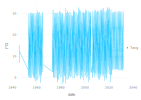

In [17]:
visualize(met_kyoto, :date, :Tavg; kind = :line)

In [18]:
obs_kyoto = load_obs(:kyoto);

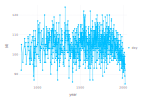

In [19]:
visualize(obs_kyoto, :year, :doy; kind = :scatterline)

In [20]:
years_kyoto = [1990:2004..., 2007:2021...];

In [21]:
config_cf_kyoto = calibrate(CF, obs_kyoto;
    configs = configure.(:kyoto, years_kyoto),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (3, 8),
        Rc = (-300, 0),
        Rf = (0, 300),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 783 evals, 688 steps, improv/step: 0.347 (last = 0.3474), fitness=80.000000000
20.03 secs, 1610 evals, 1515 steps, improv/step: 0.252 (last = 0.1729), fitness=78.000000000
30.04 secs, 2436 evals, 2341 steps, improv/step: 0.209 (last = 0.1295), fitness=75.000000000
40.05 secs, 3261 evals, 3166 steps, improv/step: 0.191 (last = 0.1418), fitness=74.000000000
50.06 secs, 4087 evals, 3992 steps, improv/step: 0.196 (last = 0.2143), fitness=74.000000000
60.06 secs, 4912 evals, 4818 steps, improv/step: 0.210 (last = 0.2797), fitness=74.000000000

Optimization stopped after 5001 steps and 62.26 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 80.32
Function evals per second = 81.83

Config for 1 system:
  CF
    Tc = 6.11141
    Rc = -13.6316
    Rf = 166.748

In [22]:
config_dts_kyoto = calibrate(DTS, obs_kyoto;
    configs = configure.(:kyoto, years_kyoto),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (-10, 30),
        Ea = (0, 200),
        Rd = (0, 500),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 846 evals, 719 steps, improv/step: 0.250 (last = 0.2503), fitness=86.000000000
20.01 secs, 1671 evals, 1539 steps, improv/step: 0.179 (last = 0.1159), fitness=80.000000000
30.01 secs, 2492 evals, 2360 steps, improv/step: 0.154 (last = 0.1084), fitness=77.000000000
40.02 secs, 3319 evals, 3187 steps, improv/step: 0.136 (last = 0.0859), fitness=76.000000000
50.02 secs, 4138 evals, 4006 steps, improv/step: 0.125 (last = 0.0818), fitness=76.000000000
60.03 secs, 4961 evals, 4829 steps, improv/step: 0.119 (last = 0.0887), fitness=76.000000000

Optimization stopped after 5001 steps and 62.11 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 80.51
Function evals per second = 82.62

Config for 1 system:
  DTS
    Ts = -2.51127
    Ea = 9.23113
    Rd = 222.503

#### CF

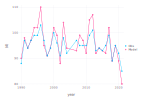

In [23]:
compare(CF, obs_kyoto, :kyoto, years_kyoto;
    config = config_cf_kyoto,
    ylim = (80, 110),
)

In [24]:
assess(CF, obs_kyoto, :kyoto, years_kyoto;
    config = config_cf_kyoto,
    metric = :rmse,
)

3.2041639575194445 d

#### DTS

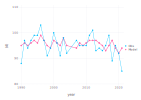

In [25]:
compare(DTS, obs_kyoto, :kyoto, years_kyoto;
    config = config_dts_kyoto,
    ylim = (80, 110),
)

In [26]:
assess(DTS, obs_kyoto, :kyoto, years_kyoto;
    config = config_dts_kyoto,
    metric = :rmse,
)

3.4253953543107007 d

#### Ensemble

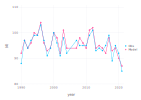

In [27]:
compare2([CF, DTS], obs_kyoto, :kyoto, years_kyoto;
    configs = [config_cf_kyoto, config_dts_kyoto],
    ylim = (80, 110),
)

In [28]:
assess2([CF, DTS], obs_kyoto, :kyoto, years_kyoto;
    configs = [config_cf_kyoto, config_dts_kyoto],
    metric = :rmse,
)

1.8708286933869707 d

### 2.2. Liestal, Switzerland

In [29]:
met_liestal = load_met(:liestal);

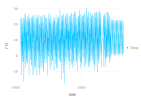

In [30]:
visualize(met_liestal, :date, :Tavg; kind = :line)

In [31]:
obs_liestal = load_obs(:liestal);

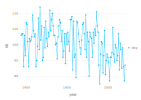

In [32]:
visualize(obs_liestal, :year, :doy; kind = :scatterline)

In [33]:
years_liestal = [1990:2014..., 2017:2021...];

In [34]:
config_cf_liestal = calibrate(CF, obs_liestal;
    configs = configure.(:liestal, years_liestal),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (3, 8),
        Rc = (-300, 0),
        Rf = (0, 300),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 831 evals, 710 steps, improv/step: 0.262 (last = 0.2620), fitness=94.000000000
20.00 secs, 1665 evals, 1543 steps, improv/step: 0.196 (last = 0.1393), fitness=93.000000000
30.01 secs, 2495 evals, 2373 steps, improv/step: 0.171 (last = 0.1241), fitness=93.000000000
40.01 secs, 3332 evals, 3210 steps, improv/step: 0.159 (last = 0.1266), fitness=92.000000000
50.02 secs, 4155 evals, 4033 steps, improv/step: 0.164 (last = 0.1810), fitness=92.000000000
60.02 secs, 4985 evals, 4864 steps, improv/step: 0.183 (last = 0.2756), fitness=92.000000000

Optimization stopped after 5001 steps and 61.69 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 81.06
Function evals per second = 83.02

Config for 1 system:
  CF
    Tc = 4.776
    Rc = -72.6158
    Rf = 158.811

In [35]:
config_dts_liestal = calibrate(DTS, obs_liestal;
    configs = configure.(:liestal, years_liestal),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (-10, 30),
        Ea = (0, 200),
        Rd = (0, 500),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.00 secs, 847 evals, 709 steps, improv/step: 0.221 (last = 0.2214), fitness=170.000000000
20.01 secs, 1691 evals, 1554 steps, improv/step: 0.156 (last = 0.1018), fitness=157.000000000
30.01 secs, 2519 evals, 2385 steps, improv/step: 0.130 (last = 0.0806), fitness=155.000000000
40.02 secs, 3358 evals, 3224 steps, improv/step: 0.127 (last = 0.1180), fitness=154.000000000
50.03 secs, 4190 evals, 4056 steps, improv/step: 0.124 (last = 0.1130), fitness=154.000000000
60.04 secs, 5011 evals, 4878 steps, improv/step: 0.117 (last = 0.0815), fitness=154.000000000

Optimization stopped after 5001 steps and 61.53 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 81.28
Function evals per second =

Config for 1 system:
  DTS
    Ts = 6.71112
    Ea = 31.519
    Rd = 179.732

#### CF

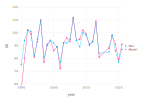

In [36]:
compare(CF, obs_liestal, :liestal, years_liestal;
    config = config_cf_liestal,
    ylim = (60, 120),
)

In [37]:
assess(CF, obs_liestal, :liestal, years_liestal;
    config = config_cf_liestal,
    metric = :rmse,
)

5.208966628164681 d

#### DTS

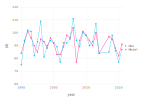

In [38]:
compare(DTS, obs_liestal, :liestal, years_liestal;
    config = config_dts_liestal,
    ylim = (60, 120),
)

In [39]:
assess(DTS, obs_liestal, :liestal, years_liestal;
    config = config_dts_liestal,
    metric = :rmse,
)

6.6783231428256 d

#### Ensemble

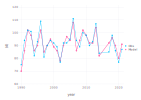

In [40]:
compare2([CF, DTS], obs_liestal, :liestal, years_liestal;
    configs = [config_cf_liestal, config_dts_liestal],
    ylim = (60, 120),
)

In [41]:
assess2([CF, DTS], obs_liestal, :liestal, years_liestal;
    configs = [config_cf_liestal, config_dts_liestal],
    metric = :rmse,
)

3.8815804341359033 d

### 2.3. Washington, D.C., USA

In [42]:
met_washingtondc = load_met(:washingtondc);

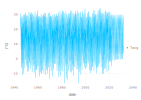

In [43]:
visualize(met_washingtondc, :date, :Tavg; kind = :line)

In [44]:
obs_washingtondc = load_obs(:washingtondc);

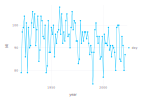

In [45]:
visualize(obs_washingtondc, :year, :doy; kind = :scatterline)

In [46]:
years_washingtondc = 1990:2021

1990:2021

In [47]:
config_cf_washingtondc = calibrate(CF, obs_washingtondc;
    configs = configure.(:washingtondc, years_washingtondc),
    index = :year,
    target = :doy,
    parameters = :CF => (;
        Tc = (3, 8),
        Rc = (-300, 0),
        Rf = (0, 300),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.01 secs, 770 evals, 657 steps, improv/step: 0.285 (last = 0.2846), fitness=116.000000000
20.02 secs, 1548 evals, 1434 steps, improv/step: 0.211 (last = 0.1493), fitness=97.000000000
30.03 secs, 2335 evals, 2222 steps, improv/step: 0.191 (last = 0.1536), fitness=93.000000000
40.03 secs, 3116 evals, 3005 steps, improv/step: 0.178 (last = 0.1405), fitness=89.000000000
50.04 secs, 3878 evals, 3767 steps, improv/step: 0.166 (last = 0.1181), fitness=88.000000000
60.04 secs, 4645 evals, 4534 steps, improv/step: 0.167 (last = 0.1747), fitness=88.000000000

Optimization stopped after 5001 steps and 66.06 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 75.70
Function evals per second = 77.3

Config for 1 system:
  CF
    Tc = 7.01305
    Rc = -173.829
    Rf = 109.801

In [48]:
config_dts_washingtondc = calibrate(DTS, obs_washingtondc;
    configs = configure.(:washingtondc, years_washingtondc),
    index = :year,
    target = :doy,
    parameters = :DTS => (;
        Ts = (-10, 30),
        Ea = (0, 200),
        Rd = (0, 500),
    ),
    stop = :stop,
    snap = :stop,
    callback,
)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.02 secs, 792 evals, 671 steps, improv/step: 0.268 (last = 0.2683), fitness=165.000000000
20.02 secs, 1584 evals, 1460 steps, improv/step: 0.195 (last = 0.1331), fitness=136.000000000
30.03 secs, 2372 evals, 2248 steps, improv/step: 0.159 (last = 0.0926), fitness=135.000000000
40.03 secs, 3158 evals, 3034 steps, improv/step: 0.146 (last = 0.1094), fitness=132.000000000
50.04 secs, 3938 evals, 3814 steps, improv/step: 0.147 (last = 0.1474), fitness=130.000000000
60.05 secs, 4725 evals, 4602 steps, improv/step: 0.149 (last = 0.1612), fitness=128.000000000

Optimization stopped after 5001 steps and 65.14 seconds
Termination reason: Max number of steps (5000) reached
Steps per second = 76.77
Function evals per second =

Config for 1 system:
  DTS
    Ts = 9.0925
    Ea = 12.3938
    Rd = 176.377

#### CF

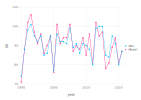

In [49]:
compare(CF, obs_washingtondc, :washingtondc, years_washingtondc;
    config = config_cf_washingtondc,
    ylim = (70, 110),
)

In [50]:
assess(CF, obs_liestal, :liestal, years_liestal;
    config = config_cf_liestal,
    metric = :rmse,
)

5.208966628164681 d

#### DTS

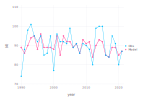

In [51]:
compare(DTS, obs_washingtondc, :washingtondc, years_washingtondc;
    config = config_dts_washingtondc,
    ylim = (70, 110),
)

In [52]:
assess(DTS, obs_liestal, :liestal, years_liestal;
    config = config_dts_liestal,
    metric = :rmse,
)

6.6783231428256 d

#### Ensemble

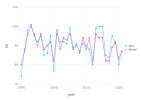

In [53]:
compare2([CF, DTS], obs_washingtondc, :washingtondc, years_washingtondc;
    configs = [config_cf_washingtondc, config_dts_washingtondc],
    ylim = (70, 110),
)

In [54]:
assess2([CF, DTS], obs_washingtondc, :washingtondc, years_washingtondc;
    configs = [config_cf_washingtondc, config_dts_washingtondc],
    metric = :rmse,
)

3.2596012026013246 d

### 2.4. Vancouver, BC, Canada

In [55]:
met_vancouver = load_met(:vancouver);

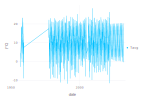

In [56]:
visualize(met_vancouver, :date, :Tavg; kind = :line)

Use parameters calibrated for Washington, DC to predict cherry blossom in Vancouver.

## 3. Predictions

In [57]:
predictions_cf = begin
    S = CF
    years = 2022:2031
    index = :year
    innerjoin(
        estimate(S, :kyoto,        years; config = config_cf_kyoto,        index, target = :kyoto        => :doy),
        estimate(S, :liestal,      years; config = config_cf_liestal,      index, target = :liestal      => :doy),
        estimate(S, :washingtondc, years; config = config_cf_washingtondc, index, target = :washingtondc => :doy),
        estimate(S, :vancouver,    years; config = config_cf_washingtondc, index, target = :vancouver    => :doy);
        on = :year
    ) |> deunitfy
end

10×5 DataFrame
 Row │ year   kyoto  liestal  washingtondc  vancouver 
     │ Int64  Int64  Int64    Int64         Int64     
─────┼────────────────────────────────────────────────
   1 │  2022     99       97            90        124
   2 │  2023     97      104            99        125
   3 │  2024     97      101            98        125
   4 │  2025     96      102            97        125
   5 │  2026     96      102            95        125
   6 │  2027     96      102            97        127
   7 │  2028     95      104            97        127
   8 │  2029     96      102            96        127
   9 │  2030     95      102            96        127
  10 │  2031     95      103            96        126

In [58]:
predictions_dts = begin
    S = DTS
    years = 2022:2031
    index = :year
    innerjoin(
        estimate(S, :kyoto,        years; config = config_dts_kyoto,        index, target = :kyoto        => :doy),
        estimate(S, :liestal,      years; config = config_dts_liestal,      index, target = :liestal      => :doy),
        estimate(S, :washingtondc, years; config = config_dts_washingtondc, index, target = :washingtondc => :doy),
        estimate(S, :vancouver,    years; config = config_dts_washingtondc, index, target = :vancouver    => :doy);
        on = :year
    ) |> deunitfy
end

10×5 DataFrame
 Row │ year   kyoto  liestal  washingtondc  vancouver 
     │ Int64  Int64  Int64    Int64         Int64     
─────┼────────────────────────────────────────────────
   1 │  2022     95       96            86         98
   2 │  2023     95       92            88         96
   3 │  2024     95       91            88         96
   4 │  2025     95       92            88         96
   5 │  2026     95       93            87         96
   6 │  2027     95       93            87         97
   7 │  2028     95       92            87         96
   8 │  2029     95       92            88         96
   9 │  2030     94       92            87         96
  10 │  2031     95       92            87         96

In [59]:
predictions_ensmemble = begin
    Ss = [CF, DTS]
    years = 2022:2031
    index = :year
    innerjoin(
        estimate2(Ss, :kyoto,        years; configs = [config_cf_kyoto,        config_dts_kyoto],        index, target = :kyoto        => :doy),
        estimate2(Ss, :liestal,      years; configs = [config_cf_liestal,      config_dts_liestal],      index, target = :liestal      => :doy),
        estimate2(Ss, :washingtondc, years; configs = [config_cf_washingtondc, config_dts_washingtondc], index, target = :washingtondc => :doy),
        estimate2(Ss, :vancouver,    years; configs = [config_cf_washingtondc, config_dts_washingtondc], index, target = :vancouver    => :doy);
        on = :year
    ) |> deunitfy
end

10×5 DataFrame
 Row │ year   kyoto  liestal  washingtondc  vancouver 
     │ Int64  Int64  Int64    Int64         Int64     
─────┼────────────────────────────────────────────────
   1 │  2022     97       96            88        111
   2 │  2023     96       98            94        110
   3 │  2024     96       96            93        110
   4 │  2025     96       97            92        110
   5 │  2026     96       98            91        110
   6 │  2027     96       98            92        112
   7 │  2028     95       98            92        112
   8 │  2029     96       97            92        112
   9 │  2030     94       97            92        112
  10 │  2031     95       98            92        111

In [60]:
CSV.write("cherry-predictions.csv", predictions_ensmemble)

"cherry-predictions.csv"